In [794]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.diagnostic import het_goldfeldquandt
from scipy.stats import t

In [795]:
# настраиваем красоту
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## 0 задание

Я выбираю $\alpha=5\%$

In [796]:
# качаем данные
data = pd.read_csv('forestfires.csv')

In [797]:
# смотрим данные
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.20,26.20,94.30,5.10,8.20,51,6.70,0.00,0.00
1,7,4,oct,tue,90.60,35.40,669.10,6.70,18.00,33,0.90,0.00,0.00
2,7,4,oct,sat,90.60,43.70,686.90,6.70,14.60,33,1.30,0.00,0.00
3,8,6,mar,fri,91.70,33.30,77.50,9.00,8.30,97,4.00,0.20,0.00
4,8,6,mar,sun,89.30,51.30,102.20,9.60,11.40,99,1.80,0.00,0.00


In [798]:
# удаляем все нулевые значения площади
data = data[data['area']!=0].reset_index(drop=True)

In [799]:
# ща будем преобразовывать категориальные признаки -- мне кажется месяц важная переменная, так как летом обычно больше пожаров
# сопоставлю каждый месяц с сезоном и сделаю дамми-переменные
data['month'] = data['month'].map({'apr':'spring',
                                   'aug':'summer',
                                   'dec':'winter',
                                   'feb':'winter',
                                   'jul':'summer',
                                   'jun':'summer',
                                   'mar':'spring',
                                   'may':'spring',
                                   'oct':'autumn',
                                   'sep':'autumn'})
data = pd.get_dummies(
    data,
    columns=['month'],
    prefix=[''],
    prefix_sep=''
)

# день недели не кажется мне важной переменной
del data['day']

## 1 задание

Text(0, 0.5, 'DMC')

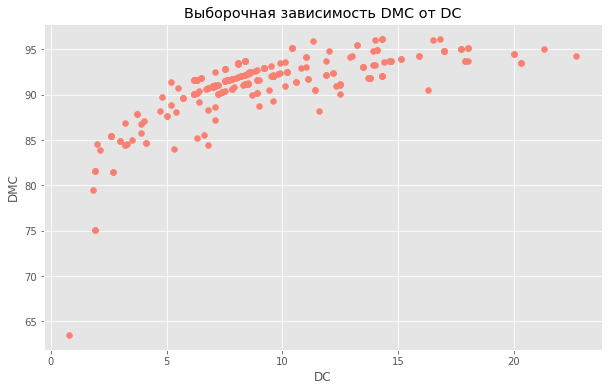

In [800]:
# гугл сказал, что ISI считается с помощью FFMC и wind. Посмотрю на их зависимость
plt.scatter(data['ISI'], data['FFMC'], color='salmon')
plt.title('Выборочная зависимость DMC от DC')
plt.xlabel('DC')
plt.ylabel('DMC')

In [801]:
model = sm.OLS(data['ISI'], data[['FFMC', 'wind']])
results = model.fit()

In [802]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ISI   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                              767.1
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                   1.23e-111
Time:                        19:21:35   Log-Likelihood:                         -749.34
No. Observations:                 270   AIC:                                      1503.
Df Residuals:                     268   BIC:                                      1510.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0988      0.006     16.074      0.000       0.087       0.111
wind           0.0698      0.124      0.563      0.574      -0.174       0.314
==============================================================================
Omnibus:                       26.584   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.355
Skew:                           0.802   Prob(JB):                     1.55e-07
Kurtosis:                       3.464   Cond. No.                         47.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Не буду брать ISI, так как это может провоцировать мультиколлинеарность

Я погуглила и кажется все индексы не связаны линейной связью, так что оставлю все. Они все служат некоторыми характеристиками, местности, где может произойти возгорание:
- $FFMC > 70$ показывает высокий уровень, повышающий вероятность возгорания. Знак: +
- $DMC > 30$ также увеличивает вероятность возникновения пожара. Знак: +
- $DC > 200$ -- высокий уровень, показывает устойчивость огня к тушению. Знак: +

Координаты по-моему также важны, возможно в какое-то место часто прихождят туристы и там чаще происходят пожары -- здесь сложно определить знак, так как может быть для какого-то места вероятность выше, для какого-то ниже (что логично). Так как я не знаю, как интерпретировать место через координаты (потому что не знаю местность), то не могу предположить знак

Температура само собой, как и относительная влажность (RH), wind, rain. Знаки +, -, +, - соответственно

Также я оставлю 3 из 4 дамми, которые сделала для сезонов -- чтобы без мультиколлинеарности. Весной я ожидаю меньше пожаров, так как холодно и сыро после зимы (-), летом и осенью больше, так как сухо и тепло (+)

In [803]:
X = data[['X', 'Y', 'FFMC', 'DMC', 'DC', 'temp', 'RH', 'wind', 'rain', 'spring', 'summer', 'autumn']]
y = data['area']

In [804]:
X.describe() # std как аналог дисперсии

,X,Y,FFMC,DMC,DC,temp,RH,wind,rain,spring,summer,autumn
count,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00
mean,4.81,4.37,91.03,114.71,570.87,19.31,43.73,4.11,0.03,0.09,0.46,0.38
std,2.38,1.17,3.71,61.79,229.98,6.18,15.08,1.88,0.40,0.29,0.50,0.49
min,1.00,2.00,63.50,3.20,15.30,2.20,15.00,0.40,0.00,0.00,0.00,0.00
25%,3.00,4.00,90.32,82.90,486.50,16.12,33.00,2.70,0.00,0.00,0.00,0.00
50%,5.00,4.00,91.70,111.70,665.60,20.10,41.00,4.00,0.00,0.00,0.00,0.00
75%,7.00,5.00,92.97,141.30,721.32,23.40,53.00,4.90,0.00,0.00,1.00,1.00
max,9.00,9.00,96.20,291.30,860.60,33.30,96.00,9.40,6.40,1.00,1.00,1.00


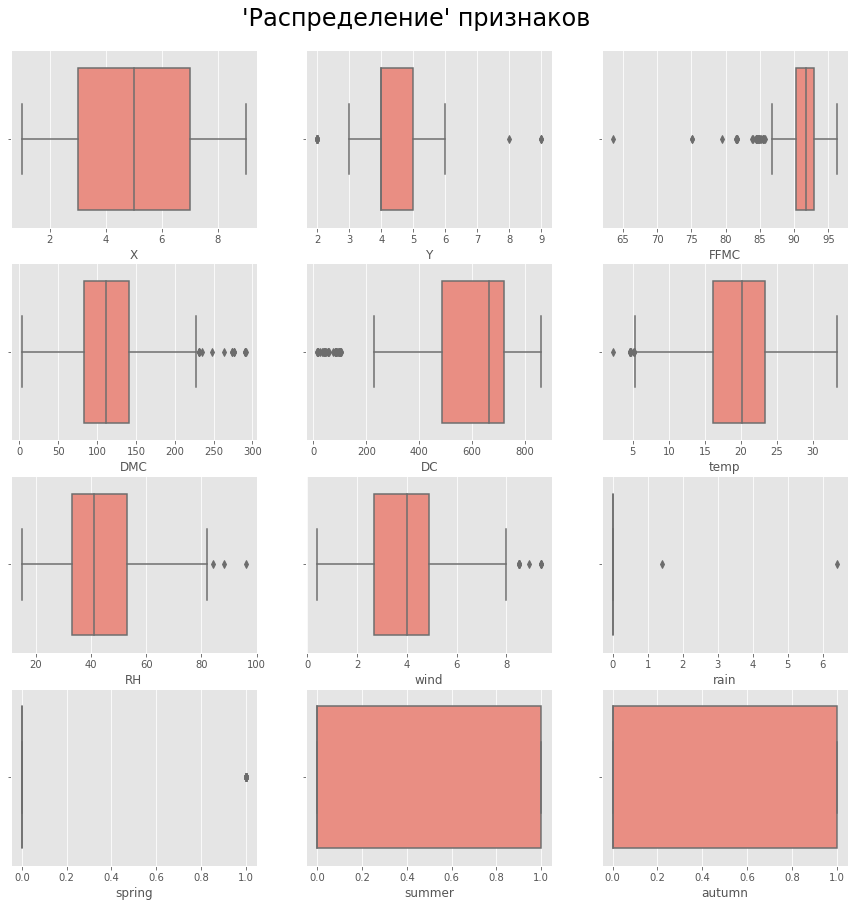

In [805]:
fig, axes = plt.subplots(4,3, figsize=(15, 15))
plt.suptitle("'Распределение' признаков", fontsize=24, y=0.92)
k = 0
for i in range(4):
    for j in range(3):
        sns.boxplot(x=X.columns[k], data=X, ax=axes[i, j], color='salmon')
        k += 1

С большинством признаков все в порядке. Все находится в пределах 25% и 75% квантилей -- относительно "равномерное" распределение. Есть три стремных графика: FFMC, rain, spring. У FFMC есть много выбросов. Но я помню, что у FFMC начиная с 70 -- критические значения индекса. Поэтому я не буду его трогать, мне нужны значения меньше 70, чтобы признак имел значение. Сначала посмотрю на их распределение до. C spring и rain я разберусь потом

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


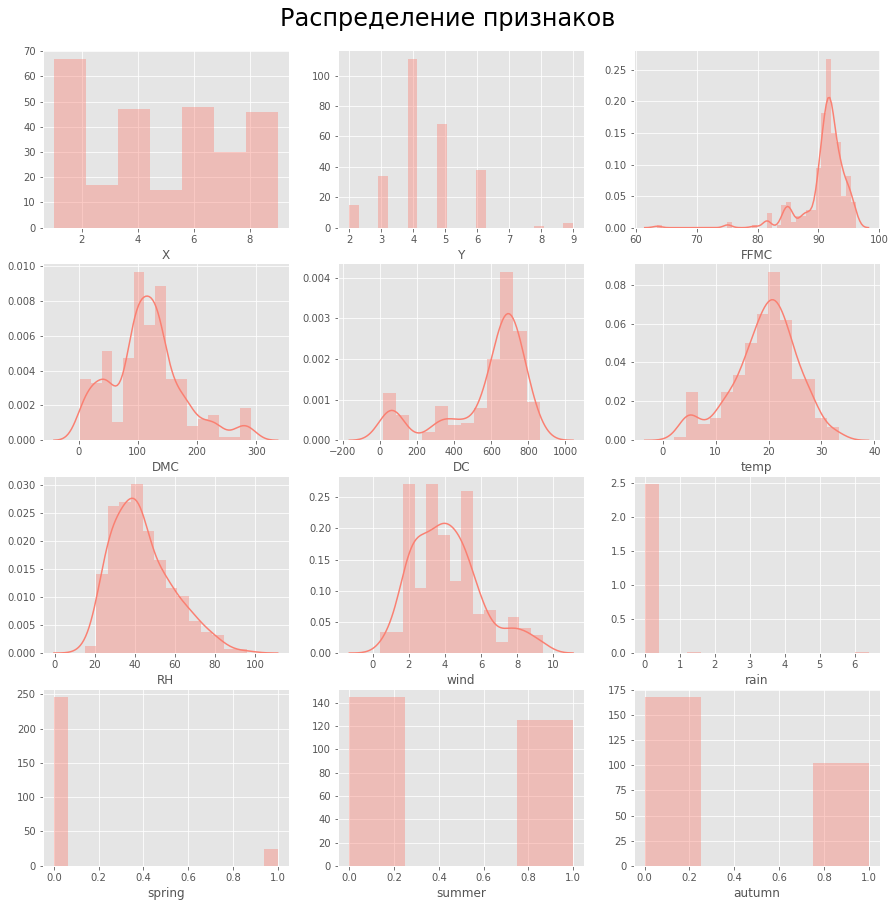

In [806]:
fig, axes = plt.subplots(4,3, figsize=(15, 15))
plt.suptitle("Распределение признаков", fontsize=24, y=0.92)
k = 0
for i in range(4):
    for j in range(3):
        if X.columns[k] in ('X', 'Y', 'spring', 'summer', 'autumn'):
            sns.distplot(X[X.columns[k]], ax=axes[i, j], kde=False, color='salmon')
        else:
            sns.distplot(X[X.columns[k]], ax=axes[i, j], color='salmon')
        k += 1

Еще можно заметить, что некоторые признаки имеют более одной моды. Но они не ярко выраженные и никак не мешают мне построить регрессию. Поэтому я ничего не буду с ними делать

In [807]:
print(np.unique(data['rain']))
display(data[(data['rain']==1.4)|(data['rain']==6.4)]) # всего два наблюдения отличаются -- это почти константный признак
# удалю его из выборки
del X['rain']

[0.  1.4 6.4]


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,autumn,spring,summer,winter
261,7,5,96.10,181.10,671.20,14.30,27.30,63,4.90,6.40,10.82,0,0,1,0
265,5,4,91.00,166.90,752.60,7.10,21.10,71,7.60,1.40,2.17,0,0,1,0


Перекос в spring естественен, так как у нас есть еще два сезона, которые мы учитываем в виде дамми в выборке. Поэтому его я, как и FFMC, оставлю -- мне нужны разные значения переменной.

Стандартизирую данные, чтобы привести их к единому масштабу

In [808]:
scaler = StandardScaler()
X_tr = pd.merge(pd.DataFrame(scaler.fit_transform(X[X.columns[:7]]), columns=X.columns[:7]),
                X[X.columns[7:]], left_index=True, right_index=True)

## 3 задание

In [809]:
for i in range(X_tr.shape[1]):
    print(f'Для {X_tr.columns[i]} VIF равен', vif(X_tr.values, i))

Для X VIF равен 1.3864129160988286
Для Y VIF равен 1.3656466460425483
Для FFMC VIF равен 1.7101752522628049
Для DMC VIF равен 2.823328822609781
Для DC VIF равен 6.124867039724709
Для temp VIF равен 3.4120113419660805
Для RH VIF равен 1.795484777846146
Для wind VIF равен 5.588227472486587
Для spring VIF равен 2.445178188816198
Для summer VIF равен 4.414966970529181
Для autumn VIF равен 3.836254883974313


In [810]:
model = sm.OLS(y, X_tr)
results = model.fit()
print(f'CN равен {results.condition_number}')

CN равен 25.7550839116962


Все круто

## 4 задание

In [811]:
model = sm.OLS(y, X_tr)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   area   R-squared (uncentered):                   0.118
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              3.163
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    0.000487
Time:                        19:21:44   Log-Likelihood:                         -1580.4
No. Observations:                 270   AIC:                                      3183.
Df Residuals:                     259   BIC:                                      3222.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              7.6955      6.167      1.248      0.213      -4.449      19.840
Y              0.2617      6.121      0.043      0.966     -11.791      12.315
FFMC          -1.3943      6.850     -0.204      0.839     -14.882      12.094
DMC           18.3469      8.801      2.085      0.038       1.017      35.677
DC           -25.4343     12.963     -1.962      0.051     -50.960       0.091
temp           9.1402      9.675      0.945      0.346      -9.911      28.192
RH            -7.4956      7.018     -1.068      0.287     -21.316       6.325
wind           2.9003      2.738      1.059      0.290      -2.491       8.291
spring       -24.7959     27.471     -0.903      0.368     -78.891      29.299
summer         0.9339     16.175      0.058      0.954     -30.917      32.785
autumn        37.9742     16.691      2.275      0.024       5.107      70.841
==============================================================================
Omnibus:                      452.947   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107893.523
Skew:                           8.961   Prob(JB):                         0.00
Kurtosis:                      99.277   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Стремные результаты, что сказать. $R^2$ очень маленький, но это ладно. У нас почти все коэффициенты не значимы (pvalue супер большие). Но F-тест говорит, что это лучше, чем предсказывать средним -- маленькая победа. А, я же константу не добавила, ща

In [812]:
X_tr['const'] = 1
model = sm.OLS(y, X_tr)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.155
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.319
Time:                        19:21:44   Log-Likelihood:                -1580.4
No. Observations:                 270   AIC:                             3185.
Df Residuals:                     258   BIC:                             3228.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              7.8064      6.224      1.254      0.211      -4.450      20.063
Y              0.1800      6.157      0.029      0.977     -11.945      12.305
FFMC          -1.1294      7.092     -0.159      0.874     -15.096      12.837
DMC           18.1095      8.962      2.021      0.044       0.461      35.758
DC           -24.1953     15.454     -1.566      0.119     -54.626       6.236
temp           9.8641     10.858      0.908      0.364     -11.518      31.246
RH            -7.0716      7.593     -0.931      0.353     -22.025       7.881
wind           2.6966      3.069      0.879      0.380      -3.347       8.740
spring       -26.6763     30.316     -0.880      0.380     -86.375      33.023
summer        -4.9080     42.685     -0.115      0.909     -88.963      79.147
autumn        31.6392     45.971      0.688      0.492     -58.887     122.166
const          6.2001     41.910      0.148      0.883     -76.330      88.730
==============================================================================
Omnibus:                      453.048   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           108005.598
Skew:                           8.965   Prob(JB):                         0.00
Kurtosis:                      99.328   Cond. No.                         67.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Стало еще хуже :)

In [813]:
# Вернусь обратно
del X_tr['const']
model = sm.OLS(y, X_tr)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   area   R-squared (uncentered):                   0.118
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              3.163
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    0.000487
Time:                        19:21:44   Log-Likelihood:                         -1580.4
No. Observations:                 270   AIC:                                      3183.
Df Residuals:                     259   BIC:                                      3222.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              7.6955      6.167      1.248      0.213      -4.449      19.840
Y              0.2617      6.121      0.043      0.966     -11.791      12.315
FFMC          -1.3943      6.850     -0.204      0.839     -14.882      12.094
DMC           18.3469      8.801      2.085      0.038       1.017      35.677
DC           -25.4343     12.963     -1.962      0.051     -50.960       0.091
temp           9.1402      9.675      0.945      0.346      -9.911      28.192
RH            -7.4956      7.018     -1.068      0.287     -21.316       6.325
wind           2.9003      2.738      1.059      0.290      -2.491       8.291
spring       -24.7959     27.471     -0.903      0.368     -78.891      29.299
summer         0.9339     16.175      0.058      0.954     -30.917      32.785
autumn        37.9742     16.691      2.275      0.024       5.107      70.841
==============================================================================
Omnibus:                      452.947   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107893.523
Skew:                           8.961   Prob(JB):                         0.00
Kurtosis:                      99.277   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Буду интерпретировать модель без константы, она получилась получше. Я угадала с DMC, temp, RH, wind, spring, summer, autumn. Не угадала с FFMC, DC. Значимыми оказались только DMC и autumn. Знаю, что нельзя нарушать заданное ранее правило, но еще DC можно притянуть и назвать значимым (но уже при 6% уровне значимости). Интерпретирую данные коэффициенты. Так как я не использовала логарифмированные признаки, то все влияют в одинаковом режиме (считая что все признаки независимы, что к сожалению не совсем так): если предиктор увеличивается на 1, то зависимая переменная меняется на количество условных единиц (здесь м2), равное коэффициенту перед предиктором. То есть, если DMC вырастет на 1, то сгоревшая площадь вырастет на 18м2. Если пожар будет не летом, а осенью, то площадь вырастет примерно на 37м2. Аналогично с DC -- однако он контринтуитивно уменьшает сгоревшую площадь. Такие дела

Насколько я помню начиная с 270 наблюдений уже можно говорить, что есть некоторая асимптотика. Поэтому применим тест Харке — Бера, который как раз посчитан автоматически и его результаты можно найти внизу таблички с результатами регрессии. Мы видим, что pvalue=0, а значит нулевая гипотеза о нормальности остатков отвергается.

## 5 задание

In [814]:
# Точечный прогноз
y_hat = model.predict(results.params, np.median(X_tr, axis=0))
y_hat

3.0304650765226064

In [815]:
# Для индивидуального
rss = results.uncentered_tss-results.ess
sigma2 = rss/(X.shape[0] - X.shape[1])

In [816]:
# в скобках расчет дисперсии для y_hat, затем +1 -- это добавка, чтобы получить дисперсию для индивидуального
var = (np.median(X_tr, axis=0)@(np.linalg.inv(X_tr.T@X_tr))@np.median(X_tr, axis=0))*sigma2 + sigma2

In [817]:
print(f'ДИ для индивидуального: [{y_hat + t.ppf(0.025, X.shape[0]-X.shape[1])*np.sqrt(var)};{y_hat + t.ppf(0.975, X.shape[0]-X.shape[1])*np.sqrt(var)}]')

ДИ для индивидуального: [-168.5127691130275;174.57369926607268]


In [818]:
# для среднего нужно просто убрать добавку в виде sigma2
var = (np.median(X_tr, axis=0)@(np.linalg.inv(X_tr.T@X_tr))@np.median(X_tr, axis=0))*sigma2
print(f'ДИ для среднего: [{y_hat + t.ppf(0.025, X.shape[0]-X.shape[1])*np.sqrt(var)};{y_hat + t.ppf(0.975, X.shape[0]-X.shape[1])*np.sqrt(var)}]')

ДИ для среднего: [-23.5199067450895;29.580836898134706]


Не люблю, когда говорят что нужно интерпретировать. Поэтому прикольно, когда получается, что-то отрицательное, что невозможно с точки зрения экономического или еще какого-нибудь смысла

## 6 задание

Честно говорю, что я не знаю, как это определяется. Могу предположить, что если у какого-то регрессора очень большие значения и большие разбросы по ним, то чисто с механической точки зрения, они вызывают сильные отклонения от линии тренда, из-за чего наблюдается гетероскедастичность. Но как-то идейно это описать, я не знаю, правда. Буду рада узнать

## 7 задание

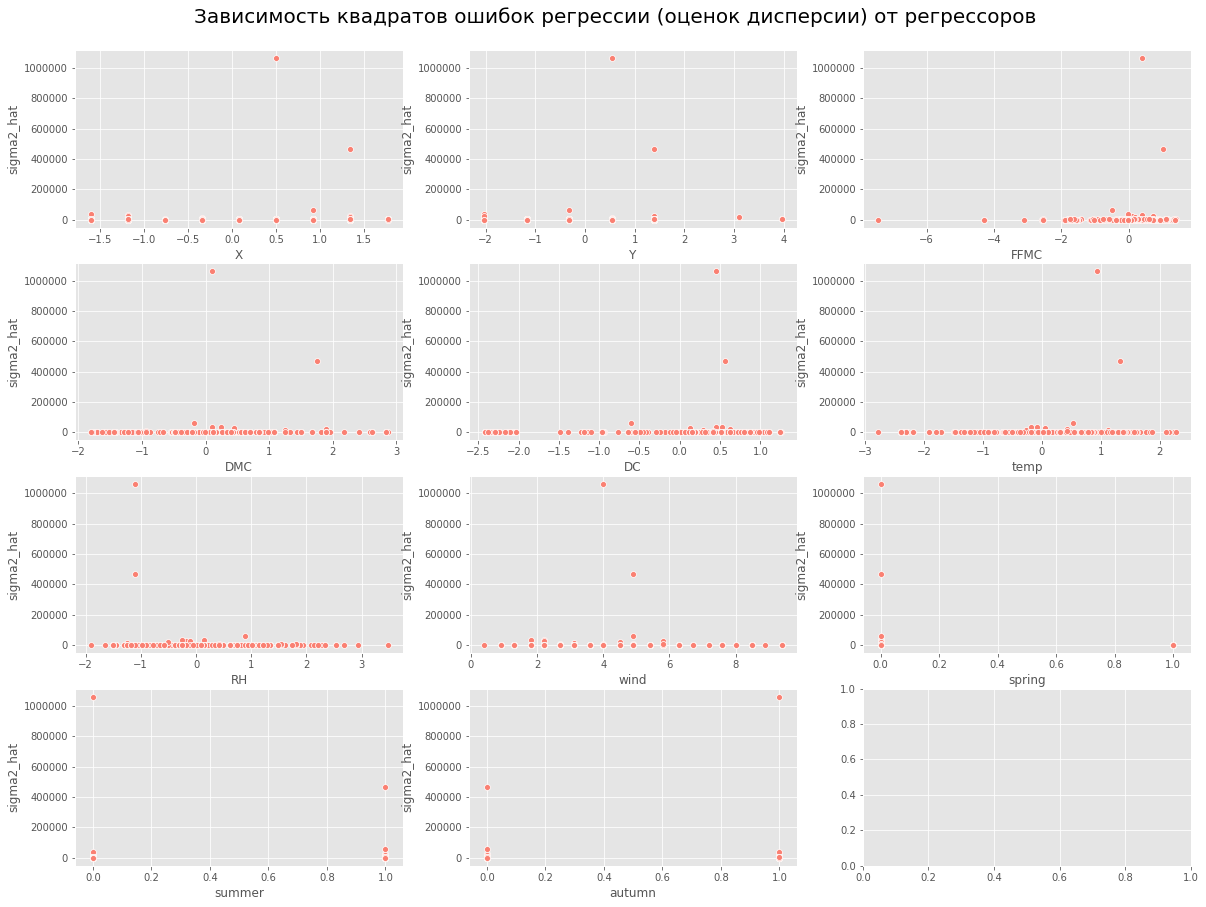

In [819]:
y_hat = model.predict(results.params)
X_tr['sigma2_hat'] = (y-y_hat)**2
fig, axes = plt.subplots(4,3, figsize=(20, 15))
plt.suptitle("Зависимость квадратов ошибок регрессии (оценок дисперсии) от регрессоров", fontsize=20, y=0.92)
t = 0
for i in range(4):
    for j in range(3):
        if t!=11:
            sns.scatterplot(x=X_tr[X_tr.columns[t]], y=X_tr['sigma2_hat'], ax=axes[i, j], color='salmon')
            t += 1

По графику кажется что зависимости нет, но возможно (и скорее всего) дело в выбросах -- очень большие ошибки сбивают все. Попробую убрать выбросы и посмотреть. Пока что отсеку по порогу 400к

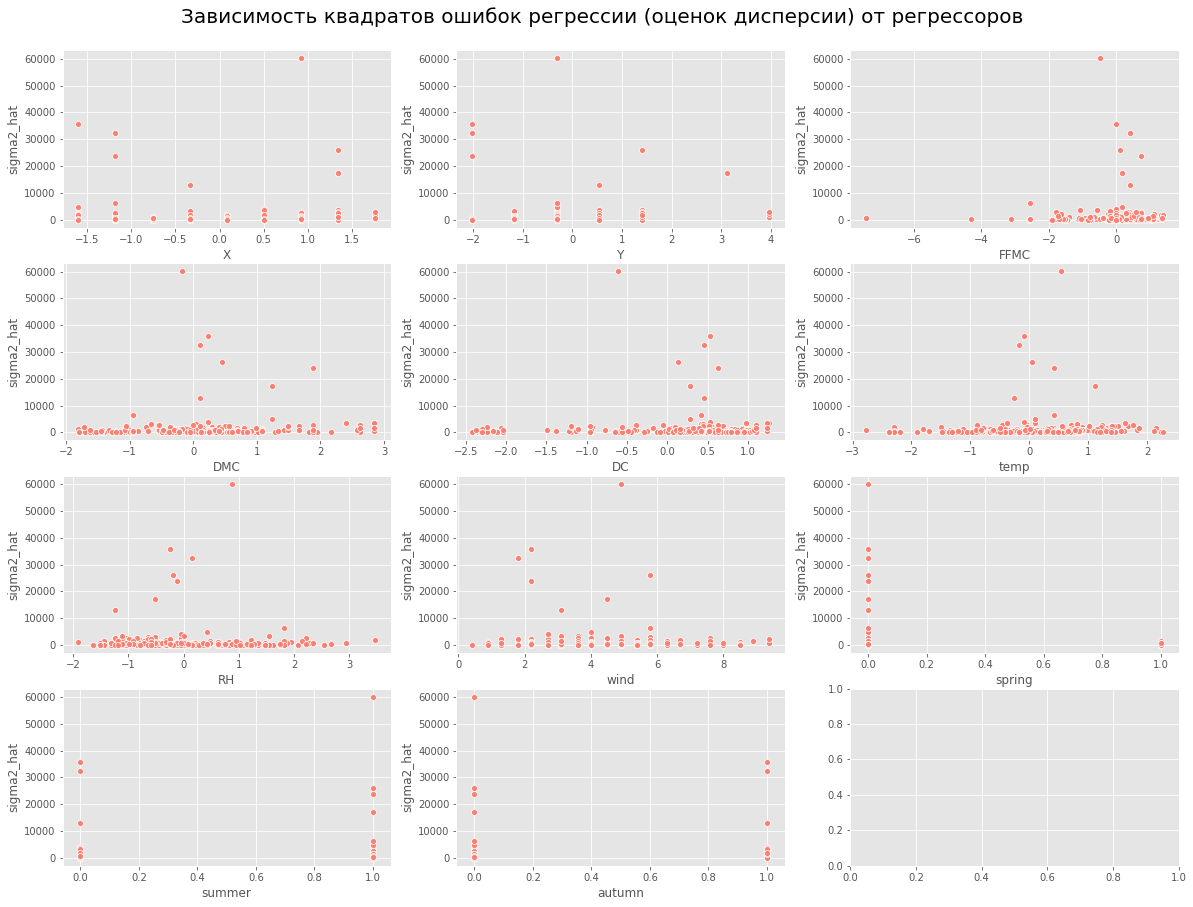

In [820]:
y_hat = model.predict(results.params)
X_tr['sigma2_hat'] = (y-y_hat)**2
fig, axes = plt.subplots(4,3, figsize=(20, 15))
plt.suptitle("Зависимость квадратов ошибок регрессии (оценок дисперсии) от регрессоров", fontsize=20, y=0.92)
t = 0
for i in range(4):
    for j in range(3):
        if t!=11:
            sns.scatterplot(x=X_tr[X_tr['sigma2_hat']<400000][X_tr.columns[t]],
                            y=X_tr[X_tr['sigma2_hat']<400000]['sigma2_hat'],
                            ax=axes[i, j],
                            color='salmon')
            t += 1

Уже что-то намечается, попробую теперь 10к

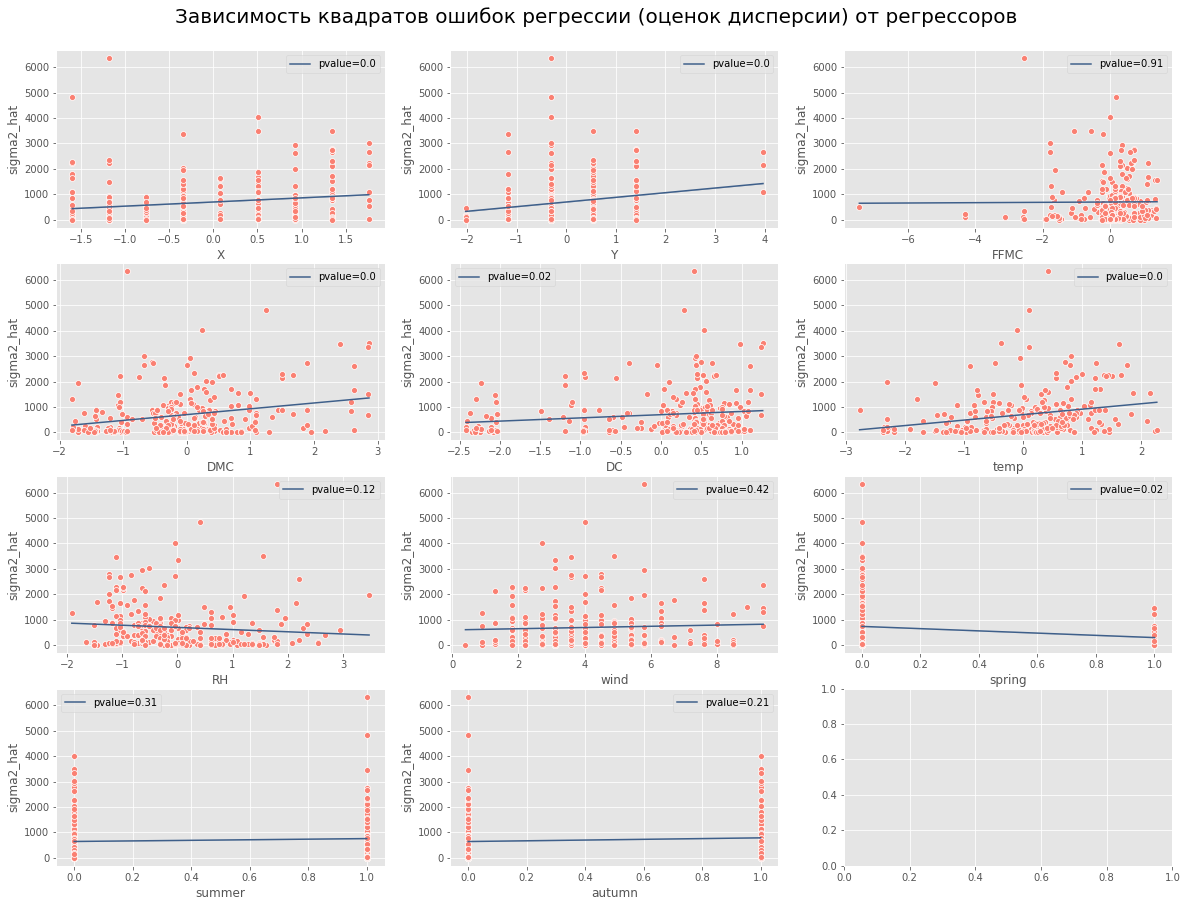

In [821]:
y_hat = model.predict(results.params)
X_tr['sigma2_hat'] = (y-y_hat)**2
fig, axes = plt.subplots(4,3, figsize=(20, 15))
plt.suptitle("Зависимость квадратов ошибок регрессии (оценок дисперсии) от регрессоров", fontsize=20, y=0.92)
k = 0 # для того, чтобы столбицы пролистывать
errors = X_tr[X_tr['sigma2_hat']<10000]['sigma2_hat']
for i in range(4):
    for j in range(3):
        if k!=11:
            pred = X_tr[X_tr['sigma2_hat']<10000][[X_tr.columns[k]]].copy()
            sns.scatterplot(x=pred[X_tr.columns[k]], y=errors, ax=axes[i, j], color='salmon')
            pred['const'] = 1
            modelka = sm.OLS(errors, pred, axis=1)
            result = modelka.fit()
            pvalue = result.pvalues[0].round(2)
            sns.lineplot(pred[X_tr.columns[k]],
                         np.sum(result.params*pred, axis=1),
                         ax=axes[i, j],
                         color='#3E5F8A',
                         legend='brief',
                         label=f'pvalue={pvalue}')
            k += 1 # переходим в следующему столбцу

Мини-регрессии говорят, что тут есть гетероскедастичность, хоть и связь не со всеми регрессорами. Мда

Сделаю еще тест Голдфельда-Квандта

In [822]:
if het_goldfeldquandt(y, X_tr, alternative='two-sided')[1] <= 0.05:
    print('Для всех регрессоров гипотеза о гомоскедастичности отвергается')
else:
    print('Для всех регрессоров гипотеза о гомоскедастичности не отвергается')
for i in X_tr.columns:
    if het_goldfeldquandt(y, X_tr[[i]], alternative='two-sided')[1] <= 0.05:
        print(f'Для {i} гипотеза о гомоскедастичности отвергается')
    else:
        print(f'Для {i} гипотеза о гомоскедастичности не отвергается')
# Прикольно :) Да, результаты вполне совпали

Для всех регрессоров гипотеза о гомоскедастичности не отвергается
Для X гипотеза о гомоскедастичности отвергается
Для Y гипотеза о гомоскедастичности отвергается
Для FFMC гипотеза о гомоскедастичности отвергается
Для DMC гипотеза о гомоскедастичности отвергается
Для DC гипотеза о гомоскедастичности отвергается
Для temp гипотеза о гомоскедастичности отвергается
Для RH гипотеза о гомоскедастичности отвергается
Для wind гипотеза о гомоскедастичности отвергается
Для spring гипотеза о гомоскедастичности отвергается
Для summer гипотеза о гомоскедастичности отвергается
Для autumn гипотеза о гомоскедастичности отвергается
Для sigma2_hat гипотеза о гомоскедастичности не отвергается


## 8 задание

In [823]:
del X_tr['sigma2_hat'] # больше не пригодится

In [824]:
np.random.seed(8)
model = sm.WLS(y, X_tr, weights=np.random.randint(1, 10, size=X_tr.shape[0]))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                   area   R-squared (uncentered):                   0.124
Model:                            WLS   Adj. R-squared (uncentered):              0.087
Method:                 Least Squares   F-statistic:                              3.334
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    0.000259
Time:                        19:22:28   Log-Likelihood:                         -1560.8
No. Observations:                 270   AIC:                                      3144.
Df Residuals:                     259   BIC:                                      3183.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              6.5941      5.214      1.265      0.207      -3.673      16.861
Y             -3.0488      5.241     -0.582      0.561     -13.369       7.271
FFMC          -2.8650      5.267     -0.544      0.587     -13.236       7.506
DMC           17.0397      7.632      2.233      0.026       2.012      32.068
DC           -21.1309     11.187     -1.889      0.060     -43.159       0.897
temp           7.2423      8.160      0.888      0.376      -8.825      23.310
RH            -4.7100      5.998     -0.785      0.433     -16.521       7.102
wind           1.7546      2.312      0.759      0.449      -2.797       6.307
spring       -12.9598     23.729     -0.546      0.585     -59.687      33.767
summer         6.0986     13.996      0.436      0.663     -21.462      33.660
autumn        36.0660     13.999      2.576      0.011       8.499      63.633
==============================================================================
Omnibus:                      423.276   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70115.482
Skew:                           7.992   Prob(JB):                         0.00
Kurtosis:                      80.311   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Результаты поменялись, но не слишком значительно. $R^2$ вырос, F-тест пройден. Даже CN вполне себе нормальный. Но значимость коэффициентов уменьшилась. Коэффициенты само собой поменялись, зато их стандартные ошибки (у некоторых) уменьшились. 

## 9 задание

In [825]:
# Вручную. Это ковариационная матрица ошибок в форме Уайта, при предположении о их независимости (что неправда)
np.diag((y-y_hat)**2) # оценки дисперсии HC0: квадраты остатков

array([[1067.16963444,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  832.1458763 ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  944.02959305, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,   40.58515958,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        6342.48940867,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,  333.58708189]])

In [826]:
# модель с HC0 -- но у них своя реализация, сейчас покажу
model = sm.OLS(y, X_tr)
results = model.fit(cov_type='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   area   R-squared (uncentered):                   0.118
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              5.887
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    1.56e-08
Time:                        19:22:28   Log-Likelihood:                         -1580.4
No. Observations:                 270   AIC:                                      3183.
Df Residuals:                     259   BIC:                                      3222.
Df Model:                          11                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              7.6955      4.555      1.689      0.091      -1.233      16.624
Y              0.2617      4.078      0.064      0.949      -7.731       8.254
FFMC          -1.3943      2.753     -0.506      0.613      -6.791       4.002
DMC           18.3469      8.042      2.282      0.023       2.586      34.108
DC           -25.4343     10.164     -2.502      0.012     -45.355      -5.513
temp           9.1402      8.278      1.104      0.270      -7.084      25.365
RH            -7.4956      4.586     -1.634      0.102     -16.484       1.493
wind           2.9003      2.037      1.424      0.155      -1.093       6.894
spring       -24.7959     16.170     -1.533      0.125     -56.489       6.897
summer         0.9339     11.569      0.081      0.936     -21.741      23.609
autumn        37.9742     14.796      2.567      0.010       8.975      66.974
==============================================================================
Omnibus:                      452.947   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107893.523
Skew:                           8.961   Prob(JB):                         0.00
Kurtosis:                      99.277   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [827]:
results.cov_HC0 # они не считают из независимыми насколько я поняла, поэтому у них получается вот такая матрица

array([[ 2.07516091e+01,  5.12899810e+00,  2.18724573e-01,
         2.58511038e+01, -2.52964315e+01,  2.00007305e+01,
        -1.23129051e+01,  6.73182646e+00, -4.06393590e+01,
        -2.75750896e+01,  1.52206112e+01],
       [ 5.12899810e+00,  1.66294701e+01,  1.48864664e+00,
         9.57025049e+00, -8.81606741e+00,  1.30275349e+01,
        -6.56184809e+00,  5.10839842e+00, -2.01074013e+01,
        -2.43700398e+01, -1.75140578e+00],
       [ 2.18724573e-01,  1.48864664e+00,  7.58175164e+00,
        -4.98876995e-02, -9.06121303e+00,  1.13672048e+00,
        -1.54917996e+00,  6.03023036e-01, -1.74564699e+01,
        -8.97804988e+00,  1.23803607e+01],
       [ 2.58511038e+01,  9.57025049e+00, -4.98876995e-02,
         6.46661134e+01, -4.71501193e+01,  1.68882303e+01,
        -2.93643893e+01,  9.31024573e+00, -5.71730192e+01,
        -3.38659372e+01,  3.01322635e+01],
       [-2.52964315e+01, -8.81606741e+00, -9.06121303e+00,
        -4.71501193e+01,  1.03307755e+02, -6.03197667e+01,
  

По сравнению с самой простой моделью значимость выросла, ура

Попробуем повторить для HC3

In [828]:
# модель с HC0 -- но у них своя реализация, сейчас покажу
model = sm.OLS(y, X_tr)
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   area   R-squared (uncentered):                   0.118
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              5.344
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                    1.24e-07
Time:                        19:22:28   Log-Likelihood:                         -1580.4
No. Observations:                 270   AIC:                                      3183.
Df Residuals:                     259   BIC:                                      3222.
Df Model:                          11                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              7.6955      4.726      1.628      0.103      -1.567      16.958
Y              0.2617      4.259      0.061      0.951      -8.086       8.609
FFMC          -1.3943      3.196     -0.436      0.663      -7.658       4.870
DMC           18.3469      8.410      2.182      0.029       1.864      34.830
DC           -25.4343     10.521     -2.417      0.016     -46.055      -4.813
temp           9.1402      8.550      1.069      0.285      -7.618      25.898
RH            -7.4956      4.782     -1.568      0.117     -16.867       1.876
wind           2.9003      2.111      1.374      0.170      -1.238       7.039
spring       -24.7959     16.752     -1.480      0.139     -57.630       8.038
summer         0.9339     11.939      0.078      0.938     -22.467      24.335
autumn        37.9742     15.254      2.489      0.013       8.077      67.872
==============================================================================
Omnibus:                      452.947   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107893.523
Skew:                           8.961   Prob(JB):                         0.00
Kurtosis:                      99.277   Cond. No.                         25.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Стало похуже :( С HC0 было лучше

## 10 задание

In [829]:
from sklearn.decomposition import PCA

In [830]:
pca = PCA(n_components=2)

In [831]:
X_pca = pca.fit_transform(X_tr)

In [832]:
print('Первые две компоненты объясняют', round(np.sum(pca.explained_variance_ratio_), 2), 'дисперсии')

Первые две компоненты объясняют 0.57 дисперсии


In [833]:
model = sm.OLS(y, X_pca)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   area   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.119
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                       0.328
Time:                        19:22:28   Log-Likelihood:                         -1596.3
No. Observations:                 270   AIC:                                      3197.
Df Residuals:                     268   BIC:                                      3204.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.8491      2.691     -0.687      0.493      -7.147       3.449
x2            -4.8692      3.664     -1.329      0.185     -12.083       2.345
==============================================================================
Omnibus:                      462.171   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118497.800
Skew:                           9.306   Prob(JB):                         0.00
Kurtosis:                     103.930   Cond. No.                         1.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CN снизилось, что логично по построению компонент. и $R^2$ снизился :)

В общем не очень модель получилась, мб стоит добавить больше компонент. Коэффициенты оба оказались незначимы, эх

## Частичка 11 задания

In [834]:
def likelihood(X, y, beta, sigma2):
    return 1/((2*np.pi)**(X.shape[0]/2)*(sigma2**(X.shape[0]/2))) * np.exp(-((y-X@beta).T@(y-X@beta))/(2*sigma2))

In [835]:
beta = np.linalg.inv(X_tr.T@X_tr)@X_tr.T@y
beta # совпали с МНК

0      7.70
1      0.26
2     -1.39
3     18.35
4    -25.43
5      9.14
6     -7.50
7      2.90
8    -24.80
9      0.93
10    37.97
dtype: float64